In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [21]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol and the time period
ticker = "NVDA"
start_date = "2018-06-08"
end_date = "2024-06-08"

# Fetch the data
nvda_data = yf.download(ticker, start=start_date, end=end_date, interval='1d')

# Display the first few rows of the dataframe
print(nvda_data.head())


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-06-08  64.989998  66.000000  64.800003  65.570000  64.957069  36045600
2018-06-11  65.442497  65.862503  65.025002  65.154999  64.545952  26537200
2018-06-12  65.422501  65.767502  64.915001  65.644997  65.031342  31916000
2018-06-13  65.660004  66.417503  65.507500  65.599998  64.986786  33820800
2018-06-14  66.055000  67.300003  65.904999  66.727501  66.103760  43001600


In [22]:
# Define the short and long window periods
short_window = 12
long_window = 26

# Calculate the EMAs
nvda_data['EMA12'] = nvda_data['Close'].ewm(span=short_window, adjust=False).mean()
nvda_data['EMA26'] = nvda_data['Close'].ewm(span=long_window, adjust=False).mean()


In [23]:
# Initialize signals
nvda_data['Signal'] = 0

# Generate buy signals
nvda_data['Signal'][short_window:] = np.where(nvda_data['EMA12'][short_window:] > nvda_data['EMA26'][short_window:], 1, 0)

# Generate trading orders
nvda_data['Position'] = nvda_data['Signal'].diff()


C:\Users\Me\AppData\Local\Temp\ipykernel_8712\971673132.py:5: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\Me\AppData\Local\Temp\ipykernel_8712\971673132.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a sl

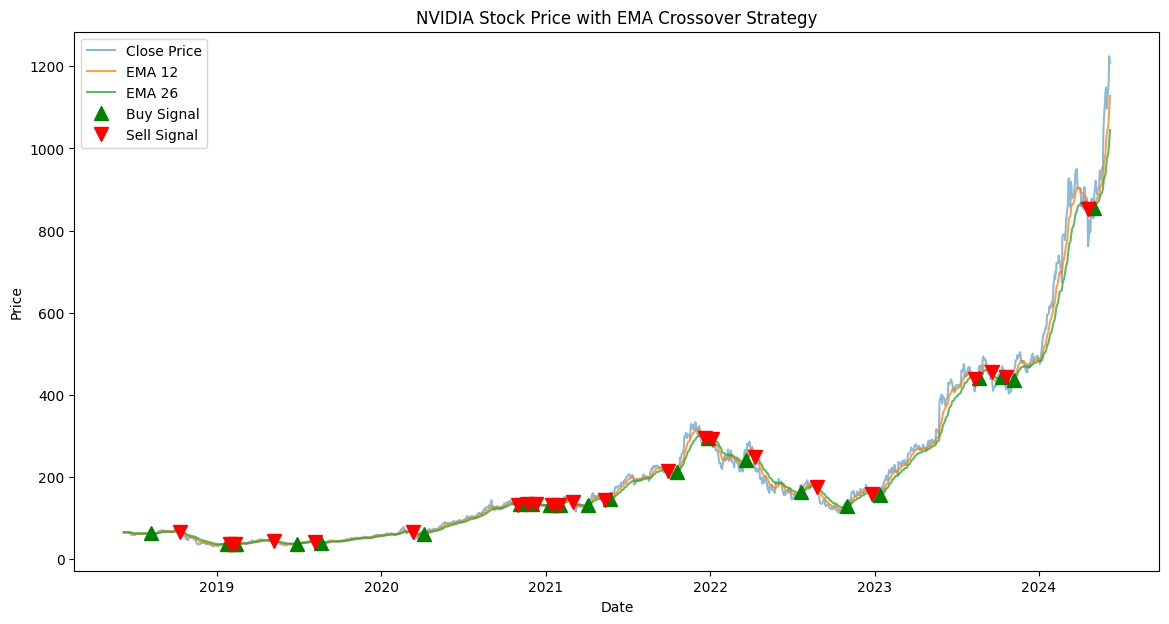

In [24]:
plt.figure(figsize=(14, 7))

# Plot closing price
plt.plot(nvda_data['Close'], label='Close Price', alpha=0.5)

# Plot EMAs
plt.plot(nvda_data['EMA12'], label='EMA 12', alpha=0.75)
plt.plot(nvda_data['EMA26'], label='EMA 26', alpha=0.75)

# Plot buy signals
plt.plot(nvda_data[nvda_data['Position'] == 1].index,
         nvda_data['EMA12'][nvda_data['Position'] == 1],
         '^', markersize=10, color='g', label='Buy Signal')

# Plot sell signals
plt.plot(nvda_data[nvda_data['Position'] == -1].index,
         nvda_data['EMA12'][nvda_data['Position'] == -1],
         'v', markersize=10, color='r', label='Sell Signal')

plt.title('NVIDIA Stock Price with EMA Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()